In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import scipy
import numpy as np
import matplotlib.pyplot as plt

import celeri

plt.rcParams["text.usetex"] = False

In [3]:
# TODO: CHANGE THIS to 1/ 1e3

DEG_PER_MYR_TO_RAD_PER_YR = 1 / 1e6
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)

# NOTE: This modification of the number of eigenvalues is for experiments
meshes[0].n_modes_strike_slip = 10
meshes[0].n_modes_dip_slip = 50
meshes[0].n_modes_total = meshes[0].n_modes_strike_slip + meshes[0].n_modes_dip_slip
meshes[0].ss_slip_constraint_rate = 0
meshes[0].ds_slip_constraint_rate = 0

# Set n_modes to the great of strike-slip or dip slip modes
# This overrides meshes[i].n_modes in mesh files
meshes[0].n_modes = np.max([meshes[0].n_modes_strike_slip, meshes[0].n_modes_dip_slip])

station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

2024-08-01 14:33:18.201 | INFO     | celeri.celeri:get_logger:6413 - Read: ../data/command/western_north_america_command.json
2024-08-01 14:33:18.201 | INFO     | celeri.celeri:get_logger:6414 - RUN_NAME: 0000000109
2024-08-01 14:33:18.202 | INFO     | celeri.celeri:get_logger:6415 - Write log file: ../runs/0000000109/0000000109.log
2024-08-01 14:33:18.202 | INFO     | celeri.celeri:read_data:302 - Reading data files
2024-08-01 14:33:18.207 | SUCCESS  | celeri.celeri:read_data:306 - Read: ../data/segment/western_north_america_segment.csv
2024-08-01 14:33:18.209 | SUCCESS  | celeri.celeri:read_data:311 - Read: ../data/block/western_north_america_block.csv
2024-08-01 14:33:18.210 | SUCCESS  | celeri.celeri:read_data:318 - Read: ../data/mesh/western_north_america_mesh_parameters.json

2024-08-01 14:33:18.324 | SUCCESS  | celeri.celeri:read_data:464 - Read: ../data/mesh/cascadia.msh
2024-08-01 14:33:18.327 | SUCCESS  | celeri.celeri:read_data:500 - Read: ../data/station/western_north_ameri

# Utilities

In [4]:
def test_agreement(estimation):
    # np.savez(
    #     "test_eigen_arrays_new.npz",
    #     estimation_eigen_cvxopt_bounded_slip_rates=estimation_eigen_cvxopt_bounded.slip_rates,
    #     estimation_eigen_cvxopt_bounded_tde_rates=estimation_eigen_cvxopt_bounded.tde_rates,
    #     estimation_eigen_cvxopt_bounded_east_vel_residual=estimation_eigen_cvxopt_bounded.east_vel_residual,
    #     estimation_eigen_cvxopt_bounded_north_vel_residual=estimation_eigen_cvxopt_bounded.north_vel_residual,
    # )

    testing_eigen_arrays = np.load("test_eigen_arrays_new.npz")
    print(
        np.allclose(
            estimation.slip_rates,
            testing_eigen_arrays["estimation_eigen_cvxopt_bounded_slip_rates"],
        )
    )

    print(
        np.allclose(
            estimation.tde_rates,
            testing_eigen_arrays["estimation_eigen_cvxopt_bounded_tde_rates"],
        )
    )
    print(
        np.allclose(
            estimation.east_vel_residual,
            testing_eigen_arrays["estimation_eigen_cvxopt_bounded_east_vel_residual"],
        )
    )
    print(
        np.allclose(
            estimation.north_vel_residual,
            testing_eigen_arrays["estimation_eigen_cvxopt_bounded_north_vel_residual"],
        )
    )

In [5]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

n_blocks = len(block)
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, n_blocks
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2024-08-01 14:33:19.102 | INFO     | celeri.celeri:get_elastic_operators:1687 - Using precomputed elastic operators
2024-08-01 14:33:19.693 | INFO     | celeri.celeri:get_slip_rate_constraints:2918 - Found 1 slip rate constraints
2024-08-01 14:33:19.697 | INFO     | celeri.celeri:get_slip_rate_constraints:2921 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)


# Full direct dense block model solve


In [6]:
index = celeri.get_index(assembly, station, block, meshes, mogi)
estimation = addict.Dict()
estimation.data_vector = celeri.get_data_vector(assembly, index, meshes)
estimation.weighting_vector = celeri.get_weighting_vector(
    command, station, meshes, index
)
estimation.operator = celeri.get_full_dense_operator(operators, meshes, index)

# Solve the overdetermined linear system
estimation.state_covariance_matrix = np.linalg.inv(
    estimation.operator.T * estimation.weighting_vector @ estimation.operator
)
estimation.state_vector = (
    estimation.state_covariance_matrix
    @ estimation.operator.T
    * estimation.weighting_vector
    @ estimation.data_vector
)

celeri.post_process_estimation(estimation, operators, station, index)

# KL functions

In [7]:
def get_index(assembly, segment, station, block, meshes, mogi):
    # Create dictionary to store indices and sizes for operator building
    index = addict.Dict()
    index.n_blocks = len(block)
    index.n_segments = len(segment)
    index.n_stations = assembly.data.n_stations
    index.n_meshes = len(meshes)
    index.n_mogis = len(mogi)
    index.vertical_velocities = np.arange(2, 3 * index.n_stations, 3)
    index.n_block_constraints = assembly.data.n_block_constraints
    index.station_row_keep_index = celeri.get_keep_index_12(3 * index.n_stations)
    index.start_station_row = 0
    index.end_station_row = 2 * index.n_stations
    index.start_block_col = 0
    index.end_block_col = 3 * index.n_blocks
    index.start_block_constraints_row = index.end_station_row
    index.end_block_constraints_row = (
        index.start_block_constraints_row + 3 * index.n_block_constraints
    )
    index.n_slip_rate_constraints = assembly.data.slip_rate_constraints.size
    index.start_slip_rate_constraints_row = index.end_block_constraints_row
    index.end_slip_rate_constraints_row = (
        index.start_slip_rate_constraints_row + index.n_slip_rate_constraints
    )
    index.n_tde_total = 0
    index.n_tde_constraints_total = 0

    # A bunch of declarations of TDE-related indices as arrays, otherwise they're dicts
    index.n_tde = np.zeros(index.n_meshes, dtype=int)
    index.n_tde_constraints = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_col = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_col = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_smoothing_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_smoothing_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_top_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_top_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_bot_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_bot_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_side_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_side_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_coup_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_coup_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ss_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ss_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ds_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ds_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)

    for i in range(index.n_meshes):
        index.n_tde[i] = meshes[i].n_tde
        index.n_tde_total += index.n_tde[i]
        index.n_tde_constraints[i] = meshes[i].n_tde_constraints
        index.n_tde_constraints_total += index.n_tde_constraints[i]
        if i == 0:
            index.start_tde_col[i] = index.end_block_col
            index.end_tde_col[i] = index.start_tde_col[i] + 2 * index.n_tde[i]
            index.start_tde_smoothing_row[i] = index.end_slip_rate_constraints_row
            index.end_tde_smoothing_row[i] = (
                index.start_tde_smoothing_row[i] + 2 * index.n_tde[i]
            )
            index.start_tde_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_constraint_row[i] = (
                index.start_tde_constraint_row[i] + index.n_tde_constraints[i]
            )
            index.start_tde_top_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_top_constraint_row[i] = index.start_tde_top_constraint_row[
                i
            ] + len(meshes[i].top_slip_idx)
            index.start_tde_bot_constraint_row[i] = index.end_tde_top_constraint_row[i]
            index.end_tde_bot_constraint_row[i] = index.start_tde_bot_constraint_row[
                i
            ] + len(meshes[i].bot_slip_idx)
            index.start_tde_side_constraint_row[i] = index.end_tde_bot_constraint_row[i]
            index.end_tde_side_constraint_row[i] = index.start_tde_side_constraint_row[
                i
            ] + len(meshes[i].side_slip_idx)
            index.start_tde_coup_constraint_row[i] = index.end_tde_side_constraint_row[
                i
            ]
            index.end_tde_coup_constraint_row[i] = index.start_tde_coup_constraint_row[
                i
            ] + len(meshes[i].coup_idx)
            index.start_tde_ss_slip_constraint_row[i] = (
                index.end_tde_coup_constraint_row[i]
            )
            index.end_tde_ss_slip_constraint_row[i] = (
                index.start_tde_ss_slip_constraint_row[i] + len(meshes[i].ss_slip_idx)
            )
            index.start_tde_ds_slip_constraint_row[i] = (
                index.end_tde_ss_slip_constraint_row[i]
            )
            index.end_tde_ds_slip_constraint_row[i] = (
                index.start_tde_ds_slip_constraint_row[i] + len(meshes[i].ds_slip_idx)
            )
        else:
            index.start_tde_col[i] = index.end_tde_col[i - 1]
            index.end_tde_col[i] = index.start_tde_col[i] + 2 * index.n_tde[i]
            index.start_tde_smoothing_row[i] = index.end_tde_constraint_row[i - 1]
            index.end_tde_smoothing_row[i] = (
                index.start_tde_smoothing_row[i] + 2 * index.n_tde[i]
            )
            index.start_tde_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_constraint_row[i] = (
                index.start_tde_constraint_row[i] + index.n_tde_constraints[i]
            )
            index.start_tde_top_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_top_constraint_row[i] = index.start_tde_top_constraint_row[
                i
            ] + len(meshes[i].top_slip_idx)
            index.start_tde_bot_constraint_row[i] = index.end_tde_top_constraint_row[i]
            index.end_tde_bot_constraint_row[i] = index.start_tde_bot_constraint_row[
                i
            ] + len(meshes[i].bot_slip_idx)
            index.start_tde_side_constraint_row[i] = index.end_tde_bot_constraint_row[i]
            index.end_tde_side_constraint_row[i] = index.start_tde_side_constraint_row[
                i
            ] + len(meshes[i].side_slip_idx)
            index.start_tde_coup_constraint_row[i] = index.end_tde_side_constraint_row[
                i
            ]
            index.end_tde_coup_constraint_row[i] = index.start_tde_coup_constraint_row[
                i
            ] + len(meshes[i].coup_idx)
            index.start_tde_ss_slip_constraint_row[i] = (
                index.end_tde_coup_constraint_row[i]
            )
            index.end_tde_ss_slip_constraint_row[i] = (
                index.start_tde_ss_slip_constraint_row[i] + len(meshes[i].ss_slip_idx)
            )
            index.start_tde_ds_slip_constraint_row[i] = (
                index.end_tde_ss_slip_constraint_row[i]
            )
            index.end_tde_ds_slip_constraint_row[i] = (
                index.start_tde_ds_slip_constraint_row[i] + len(meshes[i].ds_slip_idx)
            )

    # EIGEN: Get total number of eigenmodes
    index.n_eigen_total = 0
    for i in range(index.n_meshes):
        index.n_eigen_total += meshes[i].n_modes_strike_slip
        index.n_eigen_total += meshes[i].n_modes_dip_slip
    print(f"{index.n_eigen_total=}")

    # EIGEN: Count eigenmodes for each mesh
    index.n_modes_mesh = np.zeros(index.n_meshes, dtype=int)
    for i in range(index.n_meshes):
        index.n_modes_mesh[i] = (
            meshes[i].n_modes_strike_slip + meshes[i].n_modes_dip_slip
        )
        print(f"{index.n_modes_mesh[i]=}")

    # EIGEN: Column and row indices
    index.start_tde_col_eigen = np.zeros(index.n_meshes, dtype=int)  # Delete ???
    index.end_tde_col_eigen = np.zeros(index.n_meshes, dtype=int)  # Delete ???

    index.start_col_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_col_eigen = np.zeros(index.n_meshes, dtype=int)

    index.start_tde_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_col_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_col_eigen = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ss_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ss_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ds_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ds_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)

    # EIGEN: columns and rows for eigenmodes to velocity
    for i in range(index.n_meshes):
        # First mesh
        if i == 0:
            # Locations for eigenmodes to velocities
            index.start_col_eigen[i] = 3 * index.n_blocks
            index.end_col_eigen[i] = index.start_col_eigen[i] + index.n_modes_mesh[i]
            index.start_tde_row_eigen[i] = 0
            index.end_tde_col_eigen[i] = 2 * index.n_stations

        # Meshes after first mesh
        else:
            # Locations for eigenmodes to velocities
            index.start_col_eigen[i] = index.end_col_eigen[i - 1]
            index.end_col_eigen[i] = index.start_col_eigen[i] + index.n_modes_mesh[i]
            index.start_tde_row_eigen[i] = 0
            index.end_tde_col_eigen[i] = 2 * index.n_stations

    # EIGEN: Set initial values to follow segment slip rate constraints
    index.start_tde_constraint_row_eigen[0] = index.end_slip_rate_constraints_row
    index.end_tde_constraint_row_eigen[0] = (
        index.start_tde_constraint_row_eigen[0] + index.n_tde_constraints[i]
    )
    index.start_tde_ss_slip_constraint_row_eigen[0] = (
        index.end_slip_rate_constraints_row
    )
    index.end_tde_ss_slip_constraint_row_eigen[0] = (
        index.start_tde_ss_slip_constraint_row_eigen[0] + index.n_tde_constraints[i]
    )
    index.start_tde_ds_slip_constraint_row_eigen[0] = (
        index.end_tde_ss_slip_constraint_row_eigen[0]
    )
    index.end_tde_ds_slip_constraint_row_eigen[0] = (
        index.start_tde_ds_slip_constraint_row_eigen[0] + index.n_tde_constraints[i]
    )

    # index.start_tde_constraint_row_eigen[0] = index.end_slip_rate_constraints_row
    # index.end_tde_constraint_row_eigen[0] = (
    #     index.start_tde_constraint_row_eigen[0] + 2 * index.n_tde[i]
    # )
    # index.start_tde_ss_slip_constraint_row_eigen[0] = (
    #     index.end_slip_rate_constraints_row
    # )
    # index.end_tde_ss_slip_constraint_row_eigen[0] = (
    #     index.start_tde_ss_slip_constraint_row_eigen[0] + index.n_tde[i]
    # )
    # index.start_tde_ds_slip_constraint_row_eigen[0] = (
    #     index.end_tde_ss_slip_constraint_row_eigen[0]
    # )
    # index.end_tde_ds_slip_constraint_row_eigen[0] = (
    #     index.start_tde_ds_slip_constraint_row_eigen[0] + index.n_tde[i]
    # )

    # EIGEN: Rows for eigen to TDE boundary conditions
    for i in range(1, index.n_meshes):
        # All constraints for eigen to constraint matrix
        index.start_tde_constraint_row_eigen[i] = index.end_tde_constraint_row_eigen[
            i - 1
        ]
        index.end_tde_constraint_row_eigen[i] = (
            index.end_tde_constraint_row_eigen[i - 1] + index.n_tde_constraints[i]
        )

        # Strike-slip (ss) constraints for data vector
        # NOTE: Assuming panel structure rather than checkerboard
        # NOTE: NOT SURE THIS IS TRUE.  CHECK EIGEN TO BC OPERATOR
        index.start_tde_ss_slip_constraint_row_eigen = (
            index.end_tde_ds_slip_constraint_row_eigen[i - 1]
        )
        index.end_tde_ss_slip_constraint_row_eigen = (
            index.end_tde_ds_slip_constraint_row_eigen[i - 1]
            + len(meshes[i].ss_slip_idx)
        )

        # Dip-slip (ds) constraints for data vector
        # NOTE: Assuming panel structure rather than checkerboard
        # NOTE: NOT SURE THIS IS TRUE.  CHECK EIGEN TO BC OPERATOR
        index.start_tde_ds_slip_constraint_row_eigen = (
            index.end_tde_ds_slip_constraint_row_eigen[i - 1]
        )
        index.end_tde_ds_slip_constraint_row_eigen = (
            index.end_tde_ds_slip_constraint_row_eigen[i - 1]
            + len(meshes[i].ds_slip_idx)
        )

    # Index for block strain
    index.n_strain_blocks = np.sum(block.strain_rate_flag)
    index.n_block_strain_components = 3 * index.n_strain_blocks
    index.start_block_strain_col = index.end_tde_col[-1]
    index.end_block_strain_col = (
        index.start_block_strain_col + index.n_block_strain_components
    )

    # Index for Mogi sources
    index.start_mogi_col = index.end_block_strain_col
    index.end_mogi_col = index.start_mogi_col + index.n_mogis

    index.n_operator_rows = (
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + 2 * index.n_tde_total
        + index.n_tde_constraints_total
    )
    index.n_operator_cols = (
        3 * index.n_blocks
        + 2 * index.n_tde_total
        + 3 * index.n_strain_blocks
        + index.n_mogis
    )

    # Total number of columns for eigenmode problem
    index.n_operator_cols_eigen = (
        3 * index.n_blocks
        + index.n_eigen_total
        + 3 * index.n_strain_blocks
        + index.n_mogis
    )

    # Total number of rows for eigenmode problem
    index.n_operator_rows_eigen = (
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )
    return index


index = get_index(assembly, segment, station, block, meshes, mogi)


def search(dict, string):
    for key in dict.keys():
        if key.find(string) != -1:
            print(f"{key}: {dict[key]}")


search(index, "eigen")

index.n_eigen_total=60
index.n_modes_mesh[i]=60
n_eigen_total: 60
start_tde_col_eigen: [0]
end_tde_col_eigen: [3372]
start_col_eigen: [93]
end_col_eigen: [153]
start_tde_row_eigen: [0]
end_tde_row_eigen: [0]
start_tde_ss_slip_constraint_row_eigen: [3376]
end_tde_ss_slip_constraint_row_eigen: [3519]
start_tde_ds_slip_constraint_row_eigen: [3519]
end_tde_ds_slip_constraint_row_eigen: [3662]
start_tde_constraint_row_eigen: {0: 3376}
end_tde_constraint_row_eigen: {0: 3519}
n_operator_cols_eigen: 153
n_operator_rows_eigen: 3519


In [8]:
def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z, distance_exponent):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-(distance_matrix**distance_exponent))

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


def get_data_vector_eigen(meshes, assembly, index):
    data_vector = np.zeros(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Add GPS stations to data vector
    data_vector[index.start_station_row : index.end_station_row] = celeri.interleave2(
        assembly.data.east_vel, assembly.data.north_vel
    )

    # Add block motion constraints to data vector
    data_vector[index.start_block_constraints_row : index.end_block_constraints_row] = (
        DEG_PER_MYR_TO_RAD_PER_YR * assembly.data.block_constraints
    )

    # Add slip rate constraints to data vector
    data_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = assembly.data.slip_rate_constraints

    # Add TDE boundary condtions constraints
    for i in range(index.n_meshes):
        data_vector[
            index.start_tde_ss_slip_constraint_row_eigen[
                i
            ] : index.end_tde_ss_slip_constraint_row_eigen[i]
        ] = meshes[i].ss_slip_constraint_rate

        data_vector[
            index.start_tde_ds_slip_constraint_row_eigen[
                i
            ] : index.end_tde_ds_slip_constraint_row_eigen[i]
        ] = meshes[i].ds_slip_constraint_rate
    return data_vector


def get_weighting_vector_eigen(command, station, meshes, index):
    # Initialize and build weighting matrix
    weighting_vector = np.ones(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    weighting_vector[index.start_station_row : index.end_station_row] = (
        celeri.interleave2(1 / (station.east_sig**2), 1 / (station.north_sig**2))
    )

    weighting_vector[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] = command.block_constraint_weight

    weighting_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

    for i in range(len(meshes)):
        # TODO: This is too hacky to keep.  Revise with no reference to smoothing
        weighting_vector[
            index.start_tde_constraint_row_eigen[
                i
            ] : index.end_tde_constraint_row_eigen[i]
        ] = command.tri_con_weight * np.ones(index.n_tde_constraints[i])

    return weighting_vector


def get_eigenvectors_to_tde_slip(operators, meshes):
    for i in range(len(meshes)):
        logger.info(f"Start: Eigenvectors to TDE slip for mesh: {meshes[i].file_name}")
        # Get eigenvectors for curren mesh
        _, eigenvectors = get_eigenvalues_and_eigenvectors(
            meshes[i].n_modes,
            meshes[i].x_centroid,
            meshes[i].y_centroid,
            meshes[i].z_centroid,
            distance_exponent=1.0,  # Make this something set in mesh_parameters.json
        )

        # Create eigenvectors to TDE slip matrix
        operators.eigenvectors_to_tde_slip[i] = np.zeros(
            (
                2 * eigenvectors.shape[0],
                meshes[i].n_modes_strike_slip + meshes[i].n_modes_dip_slip,
            )
        )

        # Place strike-slip panel
        operators.eigenvectors_to_tde_slip[i][
            0::2, 0 : meshes[i].n_modes_strike_slip
        ] = eigenvectors[:, 0 : meshes[i].n_modes_strike_slip]

        # Place dip-slip panel
        operators.eigenvectors_to_tde_slip[i][
            1::2,
            meshes[i].n_modes_strike_slip : meshes[i].n_modes_strike_slip
            + meshes[i].n_modes_dip_slip,
        ] = eigenvectors[:, 0 : meshes[i].n_modes_dip_slip]
        logger.success(
            f"Finish: Eigenvectors to TDE slip for mesh: {meshes[i].file_name}"
        )


def get_full_dense_operator_eigen(operators, meshes, index):
    # Initialize linear operator
    operator = np.zeros(
        (
            2 * index.n_stations
            + 3 * index.n_block_constraints
            + index.n_slip_rate_constraints
            + index.n_tde_constraints_total,
            3 * index.n_blocks + index.n_eigen_total,
        )
    )

    # Insert block rotations and elastic velocities from fully locked segments
    operators.rotation_to_slip_rate_to_okada_to_velocities = (
        operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_block_col : index.end_block_col,
    ] = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        - operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
    )

    # Insert block motion constraints
    operator[
        index.start_block_constraints_row : index.end_block_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.block_motion_constraints

    # Insert slip rate constraints
    operator[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.slip_rate_constraints

    # EIGEN Eigenvector to velocity matrix
    for i in range(index.n_meshes):
        # Eliminate vertical elastic velocities
        tde_keep_row_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[0]
        )
        tde_keep_col_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[1]
        )

        # Create eigenvector to velocities operator
        eigen_to_velocities = (
            -operators.tde_to_velocities[i][tde_keep_row_index, :][
                :, tde_keep_col_index
            ]
            @ operators.eigenvectors_to_tde_slip[i]
        )

        # Insert eigenvector to velocities operator
        operator[
            index.start_station_row : index.end_station_row,
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = eigen_to_velocities

    # EIGEN Eigenvector to TDE boundary conditions matrix
    for i in range(index.n_meshes):
        # Create eigenvector to TDE boundary conditions matrix
        eigen_to_tde_slip_rate_constraints = (
            meshes[i].mesh_tde_modes_bc_weight
            * operators.tde_slip_rate_constraints[i]
            @ operators.eigenvectors_to_tde_slip[i]
        )

        # Insert eigenvector to TDE boundary conditions matrix
        operator[
            index.start_tde_constraint_row_eigen[
                i
            ] : index.end_tde_constraint_row_eigen[i],
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = eigen_to_tde_slip_rate_constraints

    return operator


def post_process_estimation_eigen(estimation_eigen, operators, station, index):
    """Calculate derived values derived from the block model linear estimate (e.g., velocities, undertainties)

    Args:
        estimation (Dict): Estimated state vector and model covariance
        operators (Dict): All linear operators
        station (pd.DataFrame): GPS station data
        idx (Dict): Indices and counts of data and array sizes
    """

    estimation_eigen.eigenvalues = estimation_eigen.state_vector[3 * n_blocks : :]
    estimation_eigen.predictions = (
        estimation_eigen.operator @ estimation_eigen.state_vector
    )
    estimation_eigen.vel = estimation_eigen.predictions[0 : 2 * index.n_stations]
    estimation_eigen.east_vel = estimation_eigen.vel[0::2]
    estimation_eigen.north_vel = estimation_eigen.vel[1::2]

    # Estimate slip rate uncertainties
    # Set to ones because we have no meaningful uncertainties for
    # The quadratic programming solve
    estimation_eigen.strike_slip_rate_sigma = np.zeros(index.n_segments)
    estimation_eigen.dip_slip_rate_sigma = np.zeros(index.n_segments)
    estimation_eigen.tensile_slip_rate_sigma = np.zeros(index.n_segments)

    # Calculate mean squared residual velocity
    estimation_eigen.east_vel_residual = estimation_eigen.east_vel - station.east_vel
    estimation_eigen.north_vel_residual = estimation_eigen.north_vel - station.north_vel

    # Extract TDE slip rates from state vector
    estimation_eigen.tde_rates = (
        operators.eigenvectors_to_tde_slip[0]
        @ estimation_eigen.state_vector[3 * n_blocks : :]
    )

    # Isolate strike- and dip-slip rates
    estimation_eigen.tde_strike_slip_rates = estimation_eigen.tde_rates[0::2]
    estimation_eigen.tde_dip_slip_rates = estimation_eigen.tde_rates[1::2]

    # Create a pseudo state vector that is the length of a TDE state vector
    estimation_eigen.pseudo_tde_state_vector = np.zeros(
        3 * n_blocks + 2 * index.n_tde_total
    )
    estimation_eigen.pseudo_tde_state_vector[0 : 3 * index.n_blocks] = (
        estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.pseudo_tde_state_vector[3 * index.n_blocks : :] = (
        estimation_eigen.tde_rates
    )

    # Extract segment slip rates from state vector
    estimation_eigen.slip_rates = (
        operators.rotation_to_slip_rate
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.strike_slip_rates = estimation_eigen.slip_rates[0::3]
    estimation_eigen.dip_slip_rates = estimation_eigen.slip_rates[1::3]
    estimation_eigen.tensile_slip_rates = estimation_eigen.slip_rates[2::3]

    # Calculate rotation only velocities
    estimation_eigen.vel_rotation = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_rotation = estimation_eigen.vel_rotation[0::2]
    estimation_eigen.north_vel_rotation = estimation_eigen.vel_rotation[1::2]

    # Calculate fully locked segment velocities
    estimation_eigen.vel_elastic_segment = (
        operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        0::2
    ]
    estimation_eigen.north_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        1::2
    ]

    # TODO: Calculate block strain rate velocities
    estimation_eigen.east_vel_block_strain_rate = np.zeros(len(station))
    estimation_eigen.north_vel_block_strain_rate = np.zeros(len(station))

    # Calculate TDE velocities
    estimation_eigen.vel_tde = np.zeros(2 * index.n_stations)
    for i in range(len(operators.tde_to_velocities)):

        tde_keep_row_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[0]
        )
        tde_keep_col_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[1]
        )
        estimation_eigen.vel_tde += (
            operators.tde_to_velocities[i][tde_keep_row_index, :][:, tde_keep_col_index]
            @ operators.eigenvectors_to_tde_slip[0]
            @ estimation_eigen.state_vector[
                index.start_tde_col[i] : index.end_tde_col[i]
            ]
            # @ estimation_eigen.eigenvalues
        )
    estimation_eigen.east_vel_tde = estimation_eigen.vel_tde[0::2]
    estimation_eigen.north_vel_tde = estimation_eigen.vel_tde[1::2]

# Generate all operators, weighting and data vector for KL problem

In [9]:
get_eigenvectors_to_tde_slip(operators, meshes)
data_vector_eigen = get_data_vector_eigen(meshes, assembly, index)
weighting_vector_eigen = get_weighting_vector_eigen(command, station, meshes, index)
operator_eigen = get_full_dense_operator_eigen(operators, meshes, index)

2024-08-01 14:33:22.468 | INFO     | __main__:get_eigenvectors_to_tde_slip:104 - Start: Eigenvectors to TDE slip for mesh: ../data/mesh/cascadia.msh
2024-08-01 14:33:23.241 | SUCCESS  | __main__:get_eigenvectors_to_tde_slip:133 - Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/cascadia.msh
index.start_slip_rate_constraints_row=3375
index.start_slip_rate_constraints_row + index.n_tde_constraints_total=3518
index.start_tde_constraint_row_eigen[i]=3376
index.end_tde_constraint_row_eigen[i]=3519


# KL + QP solve

In [10]:
# Options dictionary for lsqlin_qp
opts = {"show_progress": False}

lower_bound = -np.ones_like(estimation.state_vector)
upper_bound = np.ones_like(estimation.state_vector)

# TDE strike-slip
lower_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = -5
upper_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = 5

# TDE dip-slip
lower_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 0
upper_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 30

lower_bound_tde_only = lower_bound[3 * n_blocks : :]
upper_bound_tde_only = upper_bound[3 * n_blocks : :]


# Write linear inequality constraints for bounds on TDE slip
A = np.zeros(
    (2 * operators.eigenvectors_to_tde_slip[0].shape[0], index.n_operator_cols_eigen)
)
A[0 : operators.eigenvectors_to_tde_slip[0].shape[0], 3 * n_blocks :] = (
    -operators.eigenvectors_to_tde_slip[0]
)
A[operators.eigenvectors_to_tde_slip[0].shape[0] :, 3 * n_blocks :] = (
    operators.eigenvectors_to_tde_slip[0]
)

b = np.zeros(2 * operators.eigenvectors_to_tde_slip[0].shape[0])
b[0 : operators.eigenvectors_to_tde_slip[0].shape[0]] = -lower_bound_tde_only
b[operators.eigenvectors_to_tde_slip[0].shape[0] :] = upper_bound_tde_only

# TODO: Better name for ret
ret = celeri.lsqlin_qp(
    operator_eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    A,  # A=None, inequality operator
    b,  # b=None, inequality vector
    None,
    None,
    None,
    None,
    None,
    opts,
)

estimation_eigen_cvxopt_bounded = addict.Dict()
estimation_eigen_cvxopt_bounded.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen_cvxopt_bounded.state_vector = np.array(ret["x"]).flatten()
forward_data_vector_eigen = (
    operator_eigen @ estimation_eigen_cvxopt_bounded.state_vector
)
estimation_eigen_cvxopt_bounded.operator = operator_eigen
post_process_estimation_eigen(
    estimation_eigen_cvxopt_bounded, operators, station, index
)

test_agreement(estimation_eigen_cvxopt_bounded)

True
True
True
True


In [11]:
# TODO: get_full_dense_operator_eigen()
# TODO: post_process_estimation_eigen()
# TODO: get_eigenvectors_to_tde_slip()
# TODO: Generalize over multiple meshes

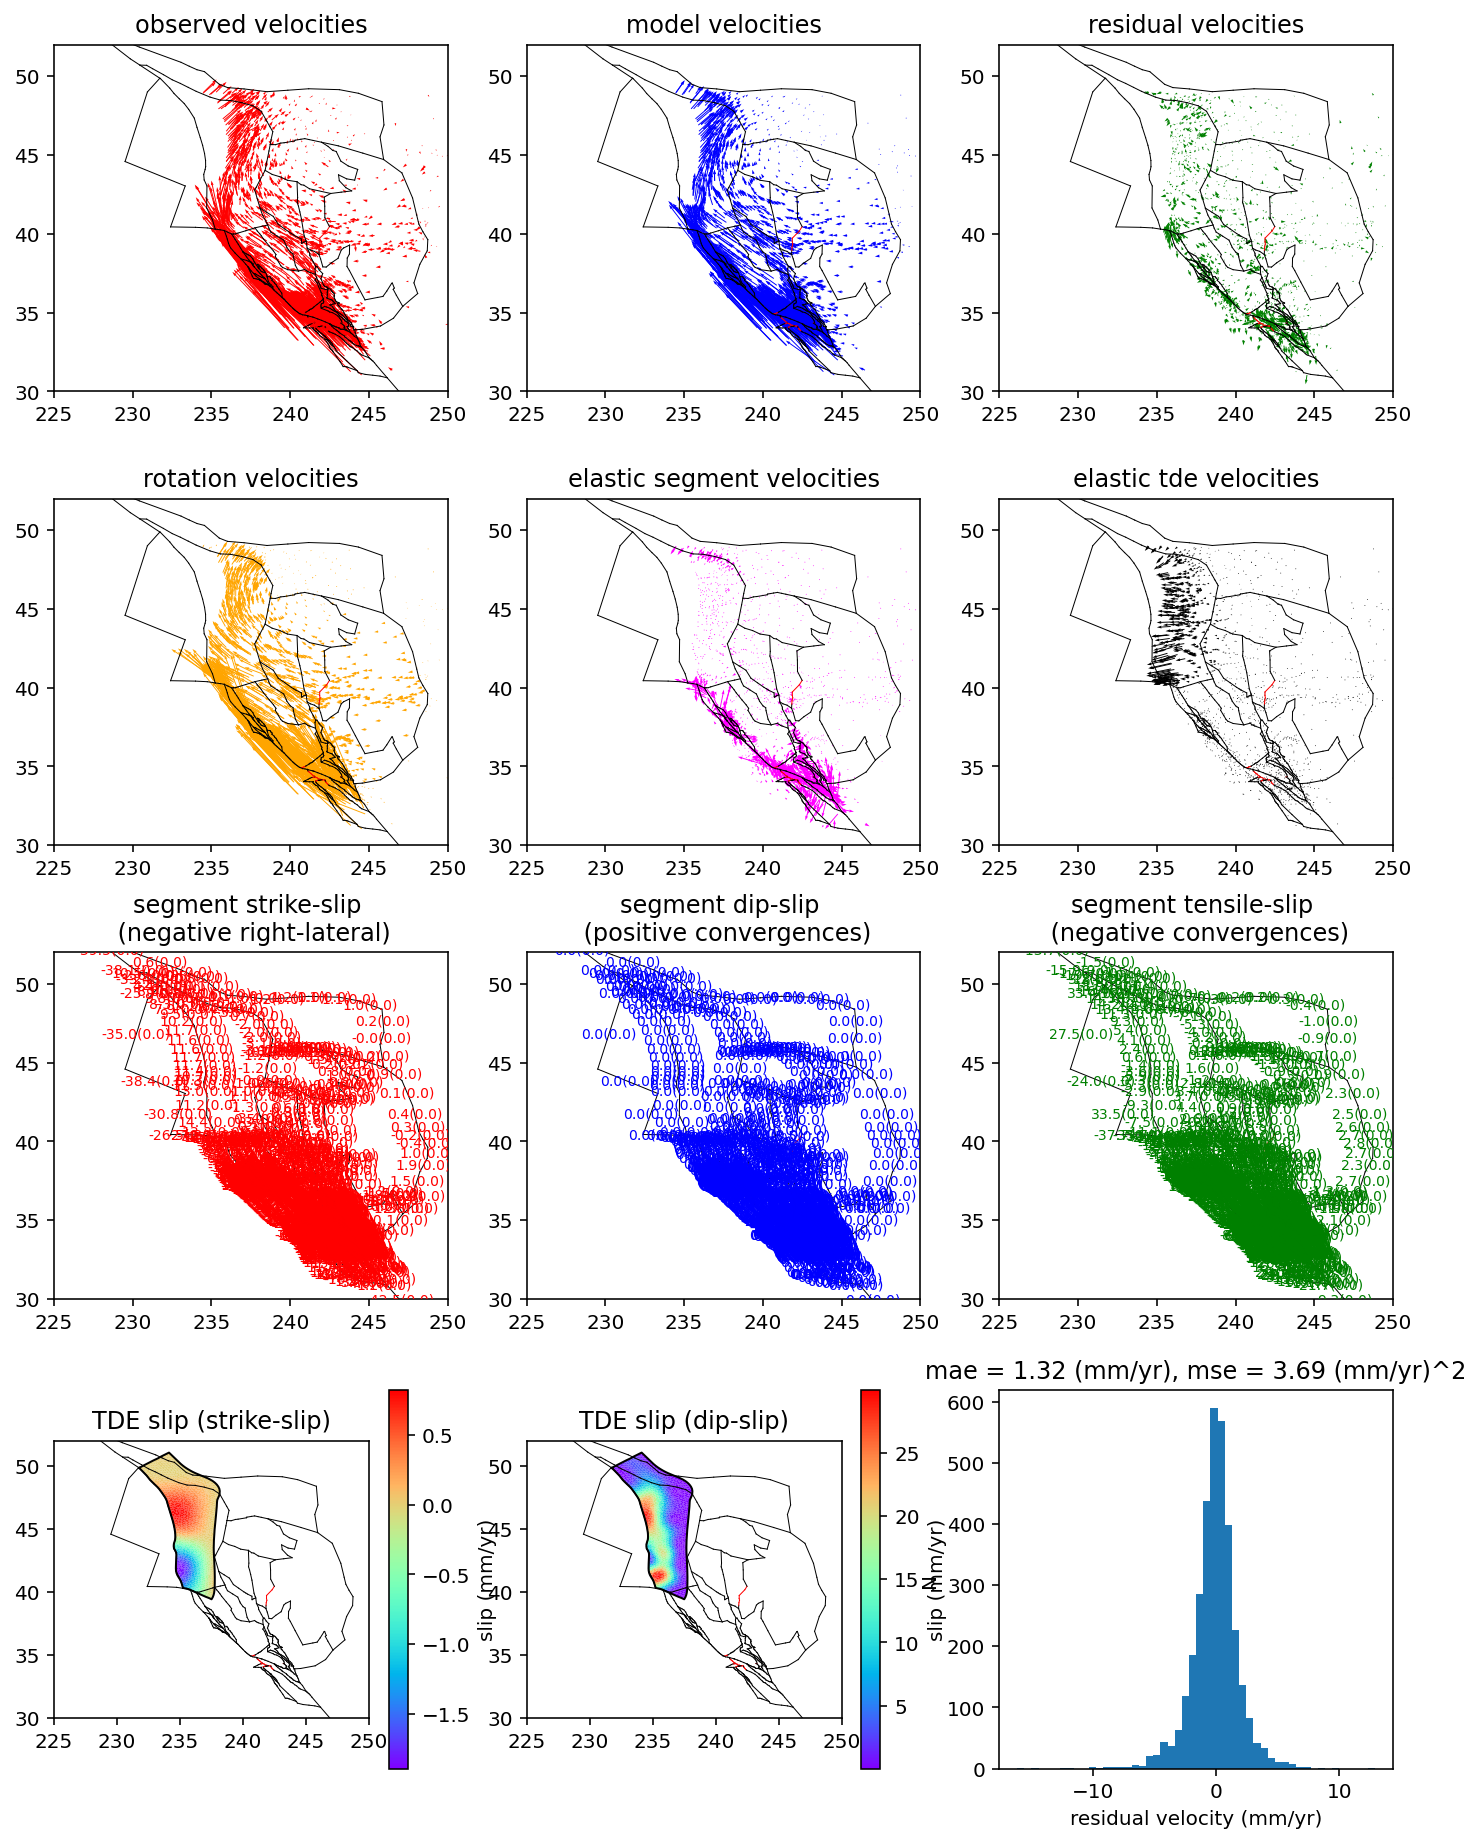

2024-08-01 14:33:30.576 | SUCCESS  | celeri.celeri:plot_estimation_summary:5553 - Wrote figures../runs/0000000109/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [12]:
# celeri.plot_estimation_summary(
#     command,
#     segment,
#     station,
#     meshes,
#     estimation_eigen_cvxopt_bounded,
#     lon_range=command.lon_range,
#     lat_range=command.lat_range,
#     quiver_scale=command.quiver_scale,
# )